In [1]:
# HIDDEN
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
# HIDDEN
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]

    row_arg = (0, len(df), nrows) if len(df) > nrows else fixed(0)
    col_arg = ((0, len(df.columns), ncols)
               if len(df.columns) > ncols else fixed(0))
    
    interact(peek, row=row_arg, col=col_arg)
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

Let's say our population is finite and we know it: a uniform over the numbers 0 to 10,000 (inclusive). (Note: You would never need statistical inference if you knew the whole population; we're just creating a playground to try out techniques.)

In [3]:
population = np.arange(10001)

We might want to know the population mean. In this case, we do!

In [4]:
np.mean(population)

5000.0

But if we only had a sample, then we would perhaps estimate (guess) that the sample mean is a reasonable approximation for the true mean.

In [5]:
sample_100 = np.random.choice(population, size=100, replace=False)
np.mean(sample_100)

5348.1

In this case, the estimator is the function `np.mean` and the parameter is 5000. The estimate is close, but it's wrong.

### Sample variance estimator for the variance of the sample mean

Here's an impractical but effective method for estimating the variance of an estimator `f`.

79290.65752957751

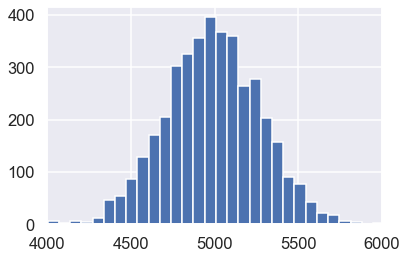

In [6]:
def var_estimate(f, pop, m=4000, n=100):
    """Estimate the variance of estimator f by the empirical variance.
    
    f: A function of a sample
    pop: An array representing the whole population
    m, n: Use m samples of size n to estimate the variance
    """
    estimates = []
    for j in range(m):
        sample = np.random.choice(pop, size=n, replace=False)
        estimates.append(f(sample))
    estimates = np.array(estimates)
    plt.hist(estimates, bins=30)
    plt.xlim(4000, 6000)
    return np.var(estimates)

var_estimate(np.mean, population)

19368.899899766835

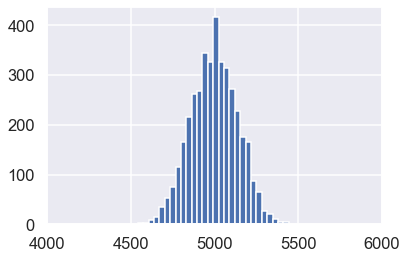

In [7]:
var_estimate(np.mean, population, n=400)

4327.692040999014

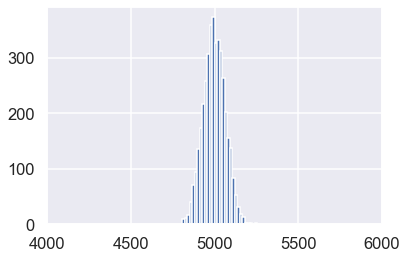

In [8]:
var_estimate(np.mean, population, n=1600)

If we know the variance of the sampling distribution and we know that the sampling distribution is approximately normal, then we know how far off a single estimate is likely to be. About 95% of estimates will be within 2 standard deviations of the mean, so for 95% of samples, the estimate will be off by the following (or less).

568.5831353097634

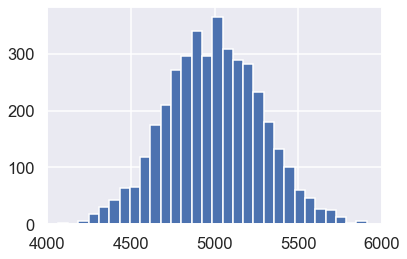

In [9]:
2 * np.sqrt(var_estimate(np.mean, population))

Unfortunately, estimating the variance required repeated sampling from the population.

### Bootstrap estimator for the variance of the sample mean

Instead, we can estimate the variance using bootstrap resampling.

In [10]:
from numba import jit

74058.58867290494

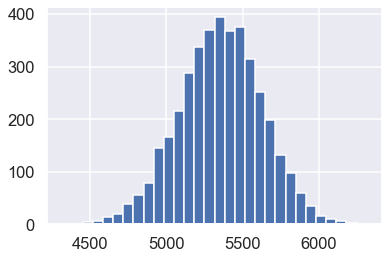

In [11]:
def bootstrap_var_estimate(f, sample, m=4000):
    """Estimate the variance of estimator f by the empirical variance.
    
    f: A function of a sample
    sample: An array representing a sample of size n
    m: Use m samples of size n to estimate the variance
    """
    estimates = []
    n = len(sample)
    for j in range(m):
        resample = np.random.choice(sample, size=n, replace=True)
        estimates.append(f(resample))
    estimates = np.array(estimates)
    plt.hist(estimates, bins=30)
    return np.mean((estimates - np.mean(estimates))**2) # same as np.var(estimates)

bootstrap_var_estimate(np.mean, sample_100)

19813.78582958132

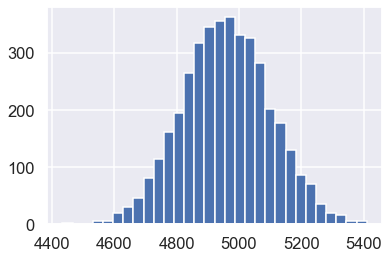

In [12]:
sample_400 = np.random.choice(population, 400, replace=False)
bootstrap_var_estimate(np.mean, sample_400)

5099.516163485052

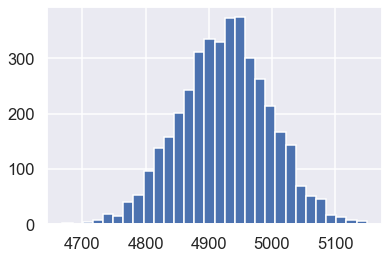

In [13]:
sample_1600 = np.random.choice(population, 1600, replace=False)
bootstrap_var_estimate(np.mean, sample_1600)

### Bootstrap confidence interval

In [14]:
def ci(sample, estimator, confidence=95, m=1000):
    """Compute a confidence interval for an estimator.
    
    sample: A DataFrame or Series
    estimator: A function from a sample DataFrame to an estimate (number)
    """
    if isinstance(sample, np.ndarray):
        sample = pd.Series(sample)
    estimates = []
    n = sample.shape[0]
    for j in range(m):
        resample = sample.sample(n, replace=True)
        estimates.append(estimator(resample))
    estimates = np.array(estimates)
    slack = 100 - confidence
    lower = np.percentile(estimates, slack/2)
    upper = np.percentile(estimates, 100 - slack/2)
    return (lower, upper)

In [15]:
ci(sample_100, np.mean)

(4814.597750000001, 5888.19125)

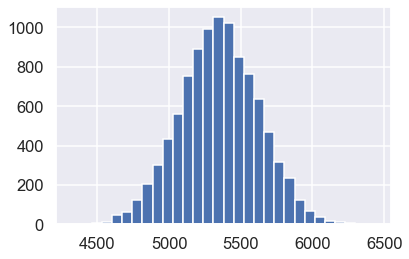

In [16]:
def bootstrap_dist(sample, estimator, m=10000):
    if isinstance(sample, np.ndarray):
        sample = pd.Series(sample)
    estimates = []
    n = sample.shape[0]
    for j in range(m):
        resample = sample.sample(n, replace=True)
        estimates.append(estimator(resample))
    plt.hist(estimates, bins=30)
    
bootstrap_dist(sample_100, np.mean)

In [17]:
# You might have to uncomment the following line to run this cell:
# !pip install tqdm

# Import a range function with a progress bar
from tqdm import tnrange

In [18]:
mean_ints = [ci(np.random.choice(population, 100), np.mean)
             for _ in tnrange(100)]

95

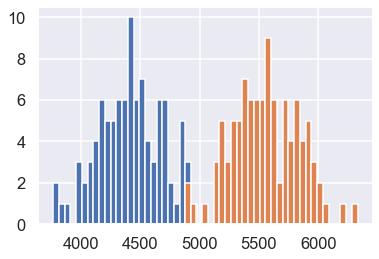

In [19]:
plt.hist([v[0] for v in mean_ints], bins=30);
plt.hist([v[1] for v in mean_ints], bins=30);
sum([v[0] <= 5000 <= v[1] for v in mean_ints])

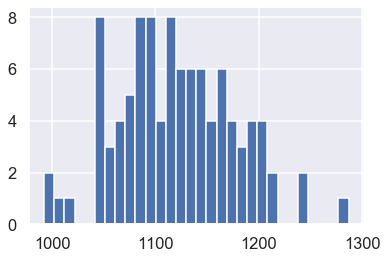

In [20]:
def width(interval):
    return interval[1] - interval[0]

plt.hist([width(v) for v in mean_ints], bins=30);

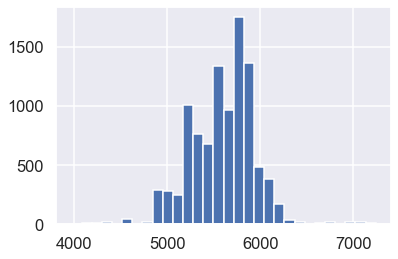

In [21]:
bootstrap_dist(sample_100, np.median)

### Median

In [22]:
ci(sample_100, np.median)

(4887.5, 6199.5)

In [23]:
width(ci(sample_100, np.median))

1243.5

In [24]:
median_ints = [ci(np.random.choice(population, 100), np.median)
               for _ in tnrange(100)]

In [25]:
sum([v[0] <= 5000 <= v[1] for v in median_ints])

97

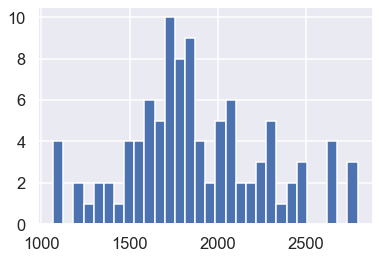

In [26]:
plt.hist([width(v) for v in median_ints], bins=30);

### Standard Deviation

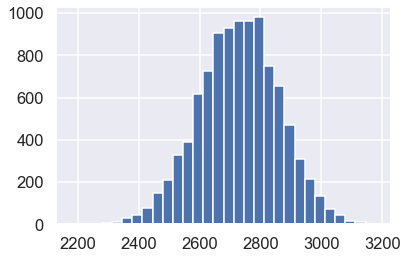

In [27]:
bootstrap_dist(sample_100, np.std)

In [28]:
ci(sample_100, np.std)

(2468.8402001725885, 2979.524741081883)

In [29]:
np.std(population)

2887.0400066504103

In [30]:
std_ints = [ci(np.random.choice(population, 100), np.std)
            for _ in tnrange(100)]

In [31]:
sum([v[0] <= np.std(population) <= v[1] for v in std_ints])

92

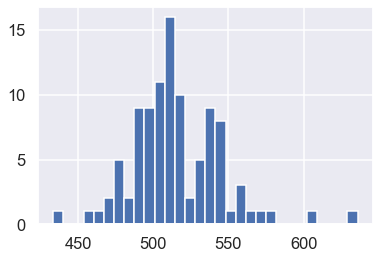

In [32]:
plt.hist([width(v) for v in std_ints], bins=30);

### 99th Percentile

In [33]:
p99 = lambda a: np.percentile(a, 99)
p99(population)

9900.0

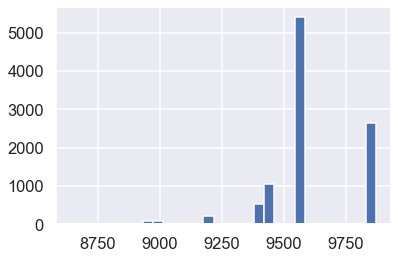

In [34]:
bootstrap_dist(sample_100, p99)

In [35]:
ci(sample_100, p99)

(9195.520000000002, 9870.0)

In [36]:
p99_ints = [ci(np.random.choice(population, 100), p99)
            for _ in tnrange(100)]

In [37]:
sum([v[0] <= p99(population) <= v[1] for v in p99_ints])

67

#### Max

In [38]:
ci(sample_100, max)

(9431.0, 9870.0)

In [39]:
max_ints = [ci(np.random.choice(population, 100), max)
            for _ in tnrange(100)]

In [40]:
sum([v[0] <= max(population) <= v[1] for v in max_ints])

0

### Classifier accuracy

In [41]:
import sklearn.datasets
data_dict = sklearn.datasets.load_breast_cancer()
cancer = pd.DataFrame(data_dict['data'], columns=data_dict['feature_names'])
cancer['bias'] = 1.0
# Target data_dict['target'] = 0 is malignant; 1 is benign
cancer['malignant'] = 1 - data_dict['target']
cancer

,mean radius,mean texture,mean perimeter,mean area,...,worst symmetry,worst fractal dimension,bias,malignant
0,17.99,10.38,122.80,1001.0,...,0.46,0.12,1.0,1
1,20.57,17.77,132.90,1326.0,...,0.28,0.09,1.0,1
2,19.69,21.25,130.00,1203.0,...,0.36,0.09,1.0,1
...,...,...,...,...,...,...,...,...,...
566,16.60,28.08,108.30,858.1,...,0.22,0.08,1.0,1
567,20.60,29.33,140.10,1265.0,...,0.41,0.12,1.0,1
568,7.76,24.54,47.92,181.0,...,0.29,0.07,1.0,0


In [42]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(cancer, test_size=0.25, random_state=100)
x_train = train.drop('malignant', axis=1).values
y_train = train['malignant'].values
x_test = test.drop('malignant', axis=1).values
y_test = test['malignant'].values

print("Training Data Size: ", len(train))
print("Test Data Size: ", len(test))

Training Data Size:  426
Test Data Size:  143


In [43]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(fit_intercept=False, C=1e-5, solver='lbfgs')
model.fit(x_train, y_train)
correct = model.predict(x_test) == y_test
np.mean(correct)

0.9300699300699301

In [44]:
ci(correct, np.mean)

(0.8881118881118881, 0.965034965034965)

### Linear regression parameter estimation

In [45]:
data_dict = sklearn.datasets.load_boston()
print(data_dict['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [46]:
house = pd.DataFrame(data_dict['data'], columns=data_dict['feature_names'])
house['MEDV'] = data_dict['target']
house

,CRIM,ZN,INDUS,CHAS,...,PTRATIO,B,LSTAT,MEDV
0,6.32e-03,18.0,2.31,0.0,...,15.3,396.90,4.98,24.0
1,2.73e-02,0.0,7.07,0.0,...,17.8,396.90,9.14,21.6
2,2.73e-02,0.0,7.07,0.0,...,17.8,392.83,4.03,34.7
...,...,...,...,...,...,...,...,...,...
503,6.08e-02,0.0,11.93,0.0,...,21.0,396.90,5.64,23.9
504,1.10e-01,0.0,11.93,0.0,...,21.0,393.45,6.48,22.0
505,4.74e-02,0.0,11.93,0.0,...,21.0,396.90,7.88,11.9


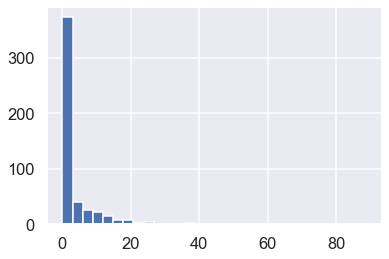

In [47]:
plt.hist(house['CRIM'], bins=30);

In [48]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(house.iloc[:,:-1], house.iloc[:,-1])
reg.coef_

array([ -0.11,   0.05,   0.02,   2.69, -17.77,   3.81,   0.  ,  -1.48,
         0.31,  -0.01,  -0.95,   0.01,  -0.52])

In [49]:
def crime_rate_slope(t):
    reg = LinearRegression().fit(t.iloc[:,:-1], t.iloc[:,-1])
    return reg.coef_[0]

ci(house, crime_rate_slope)

(-0.1611925056201077, -0.01576585050154656)